# Visualizing NURBS DIC Results from Synthetic Testing
## Sam Potter
## Current: 3/7/19

## Path and Imports

In [1]:
import sys
import os

sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\BitBucket\dic',
                 'C:/Users/potterst1/Desktop/Repositories/BitBucket/dic'])
sys.path.extend(['/workspace/stpotter/git/bitbucket/dic'])
from dic import visualize
import cv2
from matplotlib import pyplot as plt
import numpy as np
from geomdl import BSpline as bs
from geomdl import utilities as gutil
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats

## Magics

In [2]:
%matplotlib inline

## Read in results data from text files

In [3]:
# Load image
# Change these variables based on inputs
imgname = '/workspace/stpotter/git/bitbucket/dic/data/DIC_S_cropped_gray_pad_0.tiff'
image = cv2.imread(imgname, -1)

In [4]:
# Define a function for ease of use. Brittle and expects a certain format, but okay for now

def results_open(fname):
    
    f = open(fname, 'r')
    lines = f.readlines()
    lines = lines[2:]
    data = np.zeros((len(lines), 4))
    for i in range(0, len(data)):
        entry = list(map(float, lines[i].split()))
        data[i, :] = np.array(entry)
    return data
        
# Get synthetic
fname = '/workspace/stpotter/ToBox/Speckle/FullSynthSplineInterp/LargeROI/MaxIters/stretchx/stretchxsynthdef.txt'
synth = results_open(fname)

# Get minimization
fname = '/workspace/stpotter/ToBox/Speckle/FullSynthSplineInterp/LargeROI/MaxIters/stretchx/stretchxmindef.txt'
minr = results_open(fname)

In [5]:
# Set total deformation
# Change these variables based on inputs
synth_total_disp = synth[:, 2:]
min_total_disp = minr[:, 2:]

# Set number of control points
num_ctrlpts = np.sqrt(len(synth_total_disp)).astype('int')

# Set row and col max/min
rowmin_index = int(synth[:, 1].min())
rowmax_index = int(synth[:, 1].max())
colmin_index = int(synth[:, 0].min())
colmax_index = int(synth[:, 0].max())

## Visualize Applied Synthetic Displacement, Deformation

### Total Displacement

In [6]:
# Set up reference mesh surface for synthetic deformation
# Coords
coords = synth[:, :2]

# Surface
ref_surf = bs.Surface()

ref_surf.degree_u = 3
ref_surf.degree_v = 3

num_ctrlpts = np.sqrt(len(coords)).astype('int')

ref_surf.set_ctrlpts(coords.tolist(), num_ctrlpts, num_ctrlpts)

ref_surf.knotvector_u = gutil.generate_knot_vector(ref_surf.degree_u, num_ctrlpts)
ref_surf.knotvector_v = gutil.generate_knot_vector(ref_surf.degree_v, num_ctrlpts)

ref_surf.delta = 0.01

In [7]:
# Setup synthetic displacement surface
synth_disp_surf = bs.Surface()

synth_disp_surf.degree_u = 3
synth_disp_surf.degree_v = 3

synth_disp_surf.set_ctrlpts(synth_total_disp.tolist(), num_ctrlpts, num_ctrlpts)

synth_disp_surf.knotvector_u = gutil.generate_knot_vector(synth_disp_surf.degree_u, num_ctrlpts)
synth_disp_surf.knotvector_v = gutil.generate_knot_vector(synth_disp_surf.degree_v, num_ctrlpts)

synth_disp_surf.delta = 0.01

In [8]:
# Fill synthetic
U_synth = np.zeros(image.shape) * np.nan
V_synth = np.zeros(image.shape) * np.nan

for i in range(rowmin_index, rowmax_index):
    for j in range(colmin_index, colmax_index):
        u_val = (j - colmin_index) / (colmax_index - colmin_index)
        v_val = (i - rowmin_index) / (rowmax_index - rowmin_index)
        disp_synth = np.array(synth_disp_surf.surfpt(u_val, v_val))
        U_synth[i, j] = disp_synth[0]
        V_synth[i, j] = disp_synth[1]

Text(0.5, 1.0, 'Synthetic Y Displacement (Pixels)')

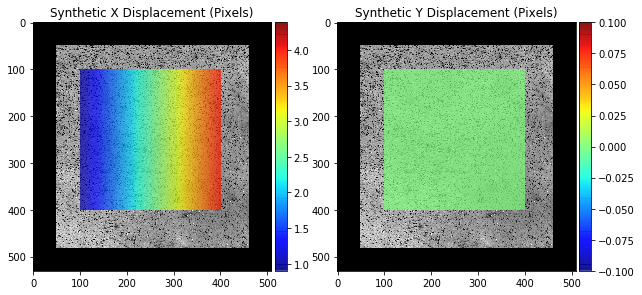

In [9]:
# Display
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))
im0 = ax0.imshow(image, cmap='gray')
Uim = ax0.imshow(U_synth, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(Uim, cax=cax0)
Umin = 0.9 * np.nanmin(U_synth)
Umax = 1.1 * np.nanmax(U_synth)
Uim.set_clim(Umin, Umax)
ax0.set_title('Synthetic X Displacement (Pixels)')

im1 = ax1.imshow(image, cmap='gray')
Vim = ax1.imshow(V_synth, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(Vim, cax=cax1)
Vmin = 0.9 * np.nanmin(V_synth)
Vmax = 0.9 * np.nanmax(V_synth)
Vim.set_clim(Vmin, Vmax)
ax1.set_title('Synthetic Y Displacement (Pixels)')

### Total Deformation

In [10]:
# Synthetic Deformation arrays
F11_synth = np.zeros(image.shape) * np.nan
F12_synth = np.zeros(image.shape) * np.nan
F21_synth = np.zeros(image.shape) * np.nan
F22_synth = np.zeros(image.shape) * np.nan

for i in range(rowmin_index, rowmax_index):
    for j in range(colmin_index, colmax_index):
        u_val = (j - colmin_index) / (colmax_index - colmin_index)
        v_val = (i - rowmin_index) / (rowmax_index - rowmin_index)
        F_val= visualize.def_grad(ref_surf, u_val, v_val, synth_total_disp)
        F11_synth[i, j] = F_val[0, 0]
        F12_synth[i, j] = F_val[0, 1]
        F21_synth[i, j] = F_val[1, 0]
        F22_synth[i, j] = F_val[1, 1]

Text(0.5, 1.0, 'Synthetic F22')

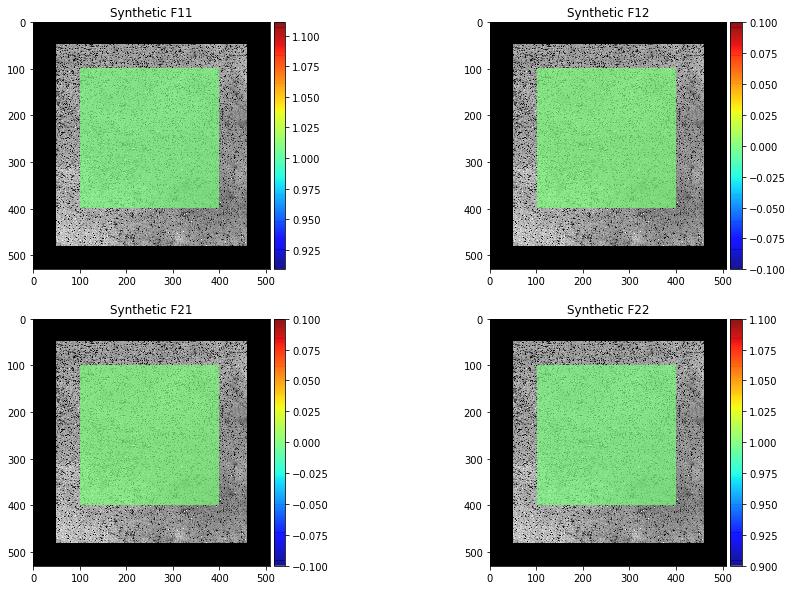

In [11]:
# Display
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15, 10))

im0 = ax0.imshow(image, cmap='gray')
F11im = ax0.imshow(F11_synth, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F11im, cax=cax0)
F11min = 0.9 * np.nanmin(F11_synth)
F11max = 1.1 * np.nanmax(F11_synth)
F11im.set_clim(F11min, F11max)
ax0.set_title('Synthetic F11')

im1 = ax1.imshow(image, cmap='gray')
F12im = ax1.imshow(F12_synth, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F12im, cax=cax1)
F12min = 0.9 * np.nanmin(F12_synth)
F12max = 1.1 * np.nanmax(F12_synth)
#F12im.set_clim(F12min, F12max)
# Manually meddling with axis limits
F12im.set_clim(-0.1, 0.1)
ax1.set_title('Synthetic F12')

im2 = ax2.imshow(image, cmap='gray')
F21im = ax2.imshow(F21_synth, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F21im, cax=cax2)
F21min = 0.9 * np.nanmin(F21_synth)
F21max = 1.1 * np.nanmax(F21_synth)
F21im.set_clim(F21min, F21max)
ax2.set_title('Synthetic F21')

im3 = ax3.imshow(image, cmap='gray')
F22im = ax3.imshow(F22_synth, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F22im, cax=cax3)
F22min = 0.9 * np.nanmin(F22_synth)
F22max = 1.1 * np.nanmax(F22_synth)
F22im.set_clim(F22min, F22max)
ax3.set_title('Synthetic F22')

## Visualize Minimization Result Displacement, Deformation

### Total Displacement

In [12]:
# Setup minimized displacement surface
min_disp_surf = bs.Surface()

min_disp_surf.degree_u = 3
min_disp_surf.degree_v = 3

min_disp_surf.set_ctrlpts(synth_total_disp.tolist(), num_ctrlpts, num_ctrlpts)

min_disp_surf.knotvector_u = gutil.generate_knot_vector(min_disp_surf.degree_u, num_ctrlpts)
min_disp_surf.knotvector_v = gutil.generate_knot_vector(min_disp_surf.degree_v, num_ctrlpts)

min_disp_surf.delta = 0.01

In [13]:
# Fill synthetic
U_min = np.zeros(image.shape) * np.nan
V_min = np.zeros(image.shape) * np.nan

for i in range(rowmin_index, rowmax_index):
    for j in range(colmin_index, colmax_index):
        u_val = (j - colmin_index) / (colmax_index - colmin_index)
        v_val = (i - rowmin_index) / (rowmax_index - rowmin_index)
        disp_synth = np.array(synth_disp_surf.surfpt(u_val, v_val))
        U_min[i, j] = disp_synth[0]
        V_min[i, j] = disp_synth[1]

Text(0.5, 1.0, 'Minimized Y Displacement (Pixels)')

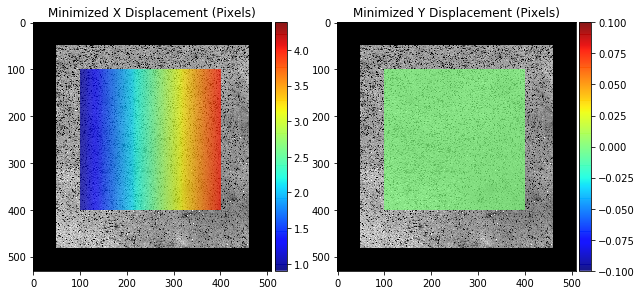

In [14]:
# Display
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))
im0 = ax0.imshow(image, cmap='gray')
Uim = ax0.imshow(U_min, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(Uim, cax=cax0)
Umin = 0.9 * np.nanmin(U_min)
Umax = 1.1 * np.nanmax(U_min)
Uim.set_clim(Umin, Umax)
ax0.set_title('Minimized X Displacement (Pixels)')

im1 = ax1.imshow(image, cmap='gray')
Vim = ax1.imshow(V_min, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(Vim, cax=cax1)
Vmin = 0.9 * np.nanmin(V_min)
Vmax = 0.9 * np.nanmax(V_min)
Vim.set_clim(Vmin, Vmax)
ax1.set_title('Minimized Y Displacement (Pixels)')

### Total Deformation

In [15]:
# Minimized Deformation arrays
F11_min = np.zeros(image.shape) * np.nan
F12_min = np.zeros(image.shape) * np.nan
F21_min = np.zeros(image.shape) * np.nan
F22_min = np.zeros(image.shape) * np.nan

for i in range(rowmin_index, rowmax_index):
    for j in range(colmin_index, colmax_index):
        u_val = (j - colmin_index) / (colmax_index - colmin_index)
        v_val = (i - rowmin_index) / (rowmax_index - rowmin_index)
        F_val= visualize.def_grad(ref_surf, u_val, v_val, min_total_disp)
        F11_min[i, j] = F_val[0, 0]
        F12_min[i, j] = F_val[0, 1]
        F21_min[i, j] = F_val[1, 0]
        F22_min[i, j] = F_val[1, 1]

Text(0.5, 1.0, 'Minimized F22')

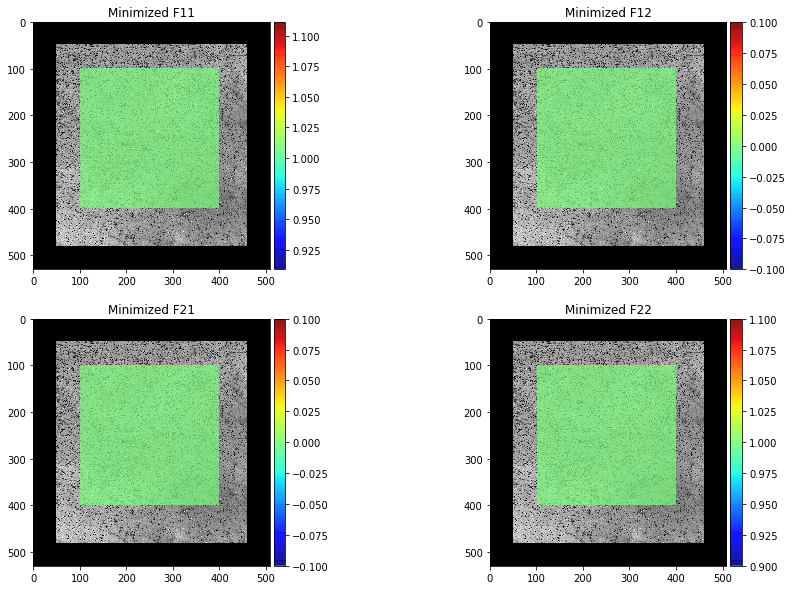

In [16]:
# Display
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15, 10))

im0 = ax0.imshow(image, cmap='gray')
F11im = ax0.imshow(F11_min, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F11im, cax=cax0)
F11min = 0.9 * np.nanmin(F11_min)
F11max = 1.1 * np.nanmax(F11_min)
F11im.set_clim(F11min, F11max)
ax0.set_title('Minimized F11')

im1 = ax1.imshow(image, cmap='gray')
F12im = ax1.imshow(F12_min, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F12im, cax=cax1)
F12min = 0.9 * np.nanmin(F12_min)
F12max = 1.1 * np.nanmax(F12_min)
#F12im.set_clim(F12min, F12max)
# Manually meddling with axis limits
F12im.set_clim(-0.1, 0.1)
ax1.set_title('Minimized F12')

im2 = ax2.imshow(image, cmap='gray')
F21im = ax2.imshow(F21_min, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F21im, cax=cax2)
F21min = 0.9 * np.nanmin(F21_min)
F21max = 1.1 * np.nanmax(F21_min)
#F21im.set_clim(F21min, F21max)
# Manually meddling with axis limits
F21im.set_clim(-0.1, 0.1)
ax2.set_title('Minimized F21')

im3 = ax3.imshow(image, cmap='gray')
F22im = ax3.imshow(F22_min, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F22im, cax=cax3)
F22min = 0.9 * np.nanmin(F22_min)
F22max = 1.1 * np.nanmax(F22_min)
F22im.set_clim(F22min, F22max)
ax3.set_title('Minimized F22')

## Compute Differences between Applied and Minimized Results

In [17]:
# Compute differences in displacement
U_diff = U_synth - U_min
V_diff = V_synth - V_min

F11_diff = F11_synth - F11_min
F12_diff = F12_synth - F12_min
F21_diff = F21_synth - F21_min
F22_diff = F22_synth - F22_min

## Visualize Differences betwteen Applied and Minimized Results 

### Total Displacement

Text(0.5, 1.0, 'Difference Y Displacement (Pixels)')

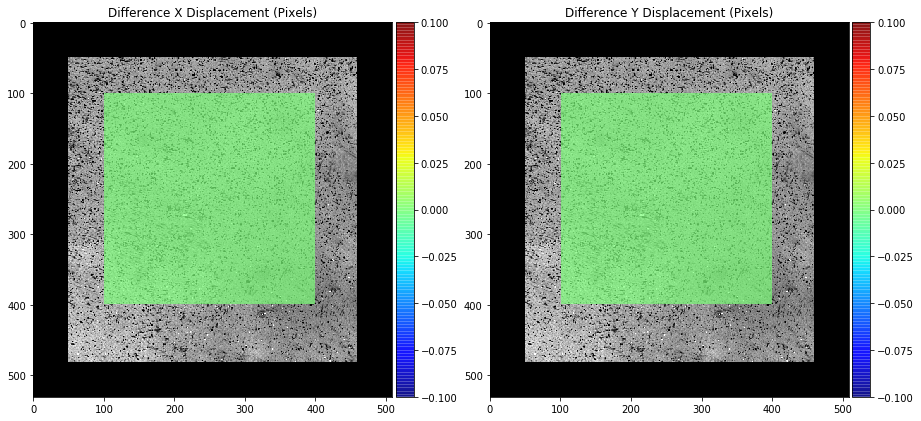

In [18]:
# Display
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 10))
im0 = ax0.imshow(image, cmap='gray')
Uim = ax0.imshow(U_diff, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(Uim, cax=cax0)
Umin = 0.9 * np.nanmin(U_diff)
Umax = 1.1 * np.nanmax(U_diff)
Uim.set_clim(Umin, Umax)
ax0.set_title('Difference X Displacement (Pixels)')

im1 = ax1.imshow(image, cmap='gray')
Vim = ax1.imshow(V_diff, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(Vim, cax=cax1)
Vmin = 0.9 * np.nanmin(V_diff)
Vmax = 0.9 * np.nanmax(V_diff)
Vim.set_clim(Vmin, Vmax)
ax1.set_title('Difference Y Displacement (Pixels)')

### Total Deformation

Text(0.5, 1.0, 'diffimized F22')

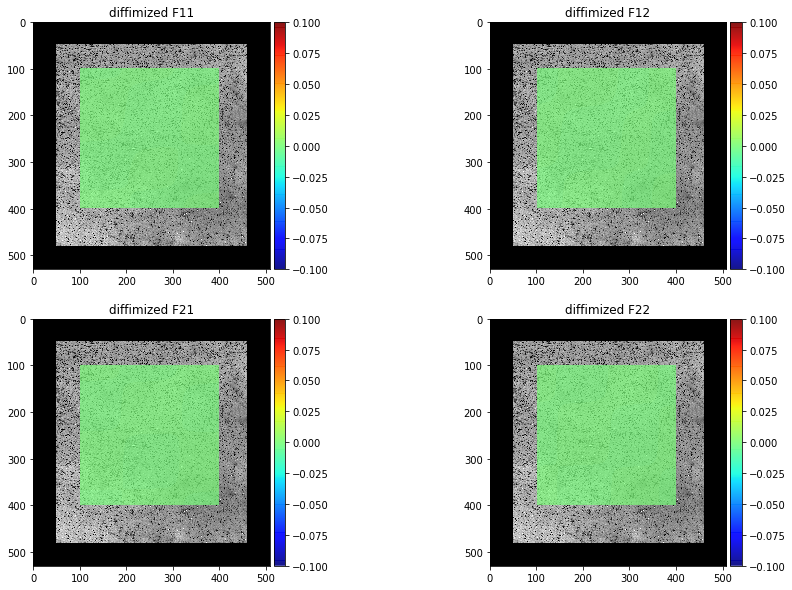

In [19]:
# Display
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15, 10))

im0 = ax0.imshow(image, cmap='gray')
F11im = ax0.imshow(F11_diff, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F11im, cax=cax0)
F11diff = 0.9 * np.nanmin(F11_diff)
F11max = 1.1 * np.nanmax(F11_diff)
#F11im.set_clim(F11diff, F11max)
# Manually meddling with axis limits
F11im.set_clim(-0.1, 0.1)
ax0.set_title('diffimized F11')

im1 = ax1.imshow(image, cmap='gray')
F12im = ax1.imshow(F12_diff, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F12im, cax=cax1)
F12diff = 0.9 * np.nanmin(F12_diff)
F12max = 1.1 * np.nanmax(F12_diff)
#F12im.set_clim(F12diff, F12max)
# Manually meddling with axis limits
F12im.set_clim(-0.1, 0.1)
ax1.set_title('diffimized F12')

im2 = ax2.imshow(image, cmap='gray')
F21im = ax2.imshow(F21_diff, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F21im, cax=cax2)
F21diff = 0.9 * np.nanmin(F21_diff)
F21max = 1.1 * np.nanmax(F21_diff)
#F21im.set_clim(F21diff, F21max)
# Manually meddling with axis limits
F21im.set_clim(-0.1, 0.1)
ax2.set_title('diffimized F21')

im3 = ax3.imshow(image, cmap='gray')
F22im = ax3.imshow(F22_diff, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F22im, cax=cax3)
F22diff = 0.9 * np.nanmin(F22_diff)
F22max = 1.1 * np.nanmax(F22_diff)
#F22im.set_clim(F22diff, F22max)
# Manually meddling with axis limits
F22im.set_clim(-0.1, 0.1)
ax3.set_title('diffimized F22')

## Compute Statistics on Differences between Applied and Minimized Results

### Report Deformation Gradient at Center of ROI

In [20]:
print('Synthetic F at Center of ROI')
print()
print(visualize.def_grad(ref_surf, 0.5, 0.5, synth_total_disp))
print()
print('Minimized F at Center of ROI')
print()
print(visualize.def_grad(ref_surf, 0.5, 0.5, min_total_disp))
print()

Synthetic F at Center of ROI

[[1.01 0.  ]
 [0.   1.  ]]

Minimized F at Center of ROI

[[1.01000000e+00 1.44051621e-09]
 [1.03011583e-10 1.00000000e+00]]



### Statistics on Differences between Applied and Minimized Results

In [21]:
# Displacement
U_diff_mean = np.nanmean(U_diff)
V_diff_mean = np.nanmean(V_diff)

U_SEM = stats.sem(U_diff, axis=None, nan_policy='omit')
V_SEM = stats.sem(V_diff, axis=None, nan_policy='omit')

In [22]:
# Deformation
F11_diff_mean = np.nanmean(F11_diff)
F12_diff_mean = np.nanmean(F12_diff)
F21_diff_mean = np.nanmean(F21_diff)
F22_diff_mean = np.nanmean(F22_diff)

F11_SEM = stats.sem(F11_diff, axis=None, nan_policy='omit')
F12_SEM = stats.sem(F12_diff, axis=None, nan_policy='omit')
F21_SEM = stats.sem(F21_diff, axis=None, nan_policy='omit')
F22_SEM = stats.sem(F22_diff, axis=None, nan_policy='omit')

In [23]:
print('Errors between synthetic and minimization results\n')
print('Displacement Errors (Mean +/- SEM)')
print('X1: {0} +/- {1}'.format(U_diff_mean, U_SEM))
print('X2: {0} +/- {1}\n'.format(V_diff_mean, V_SEM))
print('Deformation Errors (Mean +/- SEM)\n')
print('F11: {0} +/- {1}'.format(F11_diff_mean, F11_SEM))
print('F12: {0} +/- {1}'.format(F12_diff_mean, F12_SEM))
print('F21: {0} +/- {1}'.format(F21_diff_mean, F21_SEM))
print('F22: {0} +/- {1}'.format(F22_diff_mean, F22_SEM))

Errors between synthetic and minimization results

Displacement Errors (Mean +/- SEM)
X1: 0.0 +/- 0.0
X2: 0.0 +/- 0.0

Deformation Errors (Mean +/- SEM)

F11: 3.0500491074509424e-10 +/- 1.511661767416636e-11
F12: 2.62134857352818e-10 +/- 1.668687420195231e-11
F21: 3.857847924437675e-10 +/- 1.1044813877063034e-11
F22: 1.653783344342704e-11 +/- 1.1047544451033007e-11
